# Bag-of-Words Classification
---

In [1]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import gdown

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
caltech_url = 'https://drive.google.com/uc?id=1enYdrGFhROlTQkvtUooRl4H8oAbGmyXl'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 20
numTest = 10
numClasses = 10
numWords = 600

vocabPath = 'vocab.pkl'

# Dataset

## 1. Download Caltech-101 dataset

In [3]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Downloading Caltech-101')
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        gdown.download(caltech_url, caltech_filename, quiet=False)
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


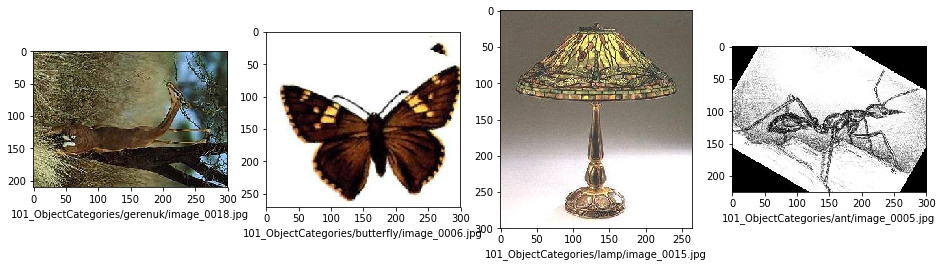

In [4]:
# Select train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1][:numClasses]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## 1. SIFT helper functions

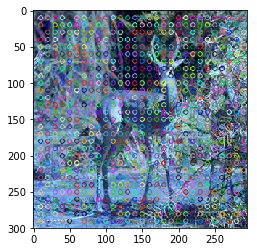

In [5]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

## 2. Visual Words (Vector Quantization Coding)

In [6]:
# Train vocabulary
random.seed(100)
if not os.path.exists(vocabPath):
    # Get PHOW features from 5 random training image for each class to build a dictionary
    print("Extracting PHOW features from some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in random.sample(sublist, 5)]
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

Load the trained visual words...
Done!


In [7]:
# Works only when vocab.pkl is first created
try:
    import collections
    myCounter = collections.Counter(bestLabels.flatten())
    plt.plot(sorted(myCounter.values()))    
except NameError:
    pass

# Classification - SVM

## Spatial Pyramid Representation

In [8]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 1x1
    hist_11 = getSpatialHistogram(1, 1, kp, words, cols, rows)

    # Spatial Binning - 2x2
    hist_22 = getSpatialHistogram(2, 2, kp, words, cols, rows)
    
    # Spatial Binning - 4x4
    hist_44 = getSpatialHistogram(4, 4, kp, words, cols, rows)

    hist = np.concatenate((hist_11, hist_22, hist_44), axis=0)
    hist /= np.sum(hist)
    return hist    

def getSpatialHistogram(binX, binY, kp, words, cols, rows):        
    ### Compute the histogram in each spatial bin.
    ### The histogram should be normalized in each bin.
    ### Then, concatenate them into one vector.
    
    hist = np.zeros((binX, binY, numWords), dtype=np.float32)
    
    for i in range(len(kp)):
        c, r = kp[i].pt
        bin_row = np.ceil(rows / binY)
        bin_col = np.ceil(cols / binX)
        hist[int(r / bin_row), int(c / bin_col), words[i]] += 1
    
    hist = hist.flatten()
    hist /= np.sum(hist)
    
    return hist

## 1. Genarate spatial pyramid representation for Training Images

In [9]:
# Extract spatial pyramid representations for all training images
print('Extract spatial pyramid representations for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spatial pyramid representations for all training images
gerenuk hawksbill headphone ant butterfly lamp strawberry water_lilly chandelier dragonfly 
done!


## 2. Train SVM

In [10]:
# Setting training data (BoW, label) for SVM
print('Setting training data (BoW, label) for SVM')
train_bow = []
train_labels = []
numSpatialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
    
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))

print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data (BoW, label) for SVM
train_bow:  (200, 12600)
train_labels:  (200, 1)


In [11]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

print('Done!')

Training SVM...
Elapsed time: 0.14537715911865234s
Done!


In [12]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.970000


## 3. Test trained SVM

In [13]:
# Extract spatial pyramid representations for all test images

print('Extract spatial pyramid representations for all test images\n')
BoW_test_ll = []

# Get Bow_test_ll
for c, image_list in zip(classes, test_image_ll):
    print(c, end=' '),
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)
   
print('\ndone!')

Extract spatial pyramid representations for all test images

gerenuk hawksbill headphone ant butterfly lamp strawberry water_lilly chandelier dragonfly 
done!


In [14]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
test_bow = []
test_labels = []
numSpatialHist = len(BoW_test_ll[0][0])

for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))
    
test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses,1))

print(test_bow.shape)
print(test_labels.shape)

Setting test data(BoW, label) for SVM
(100, 12600)
(100, 1)


In [15]:
# Test Accuracy may be different.
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

Test Accuracy:   0.58


## 4. Sample Results

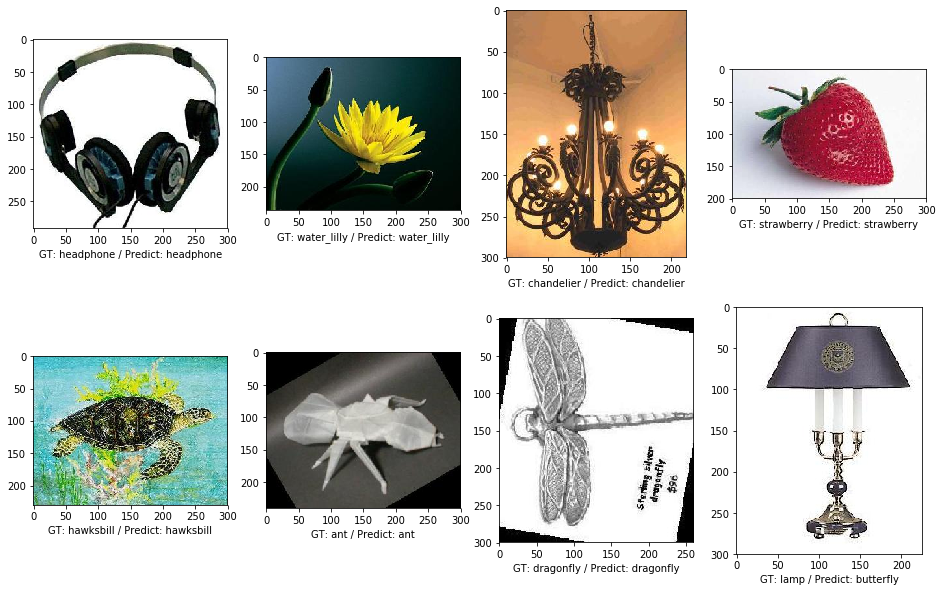

In [16]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Classify sample image

- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

Text(0.5, 0, 'Prediction: butterfly')

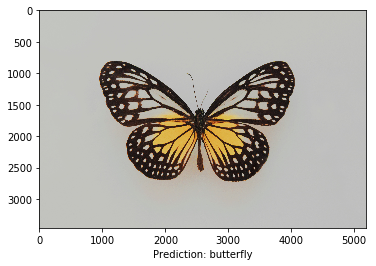

In [17]:
img_fpath = './butterfly.jpg'  # Path to a new image
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

# Extract Image Descriptor
bow_sample = getImageDescriptor(img)

# Hellinger's kernel
temp = np.sqrt(bow_sample)
temp -= np.average(temp)
if np.std(temp) != 0:
    temp /= np.std(temp)
sample_bow = np.tile(temp, (100, 1))

# Prediction
prediction = int(np.average(svm.predict(sample_bow)[1]))

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))